In [ ]:
import numpy as np
from landlab import RasterModelGrid
from rasterio import open as rio_open
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# Step 1: Load 3-meter DEM that is clipped to the Beamon watershed shape already. 
# ---------------------------------------------------------------------------
dem_path = r"E:\Landlab\3m_clipped_Beamon.tif"

with rio_open(dem_path) as src:
    dem_data = src.read(1)  # Read first band
    nodata_value = src.nodata  # Retrieve NoData value (-9999)
    spacing_3m = src.transform[0]  # Pixel size
    nrows, ncols = dem_data.shape  # Rows and columns of the DEM

# Replace nodata values with a numerical placeholder (-9999)
dem_cleaned = np.where(dem_data == nodata_value, -9999, dem_data)

# ---------------------------------------------------------------------------
# Step 2: Initialize Landlab Grid
# ---------------------------------------------------------------------------
grid = RasterModelGrid((nrows, ncols), xy_spacing=spacing_3m)

# Add the DEM elevation data to the grid
elevation = grid.add_field(
    "topographic__elevation",
    dem_cleaned.flatten(),
    at="node"
)

# ---------------------------------------------------------------------------
# Step 3: Identify Outlet Node
# ---------------------------------------------------------------------------
# Find all potential outlet nodes (boundary nodes with valid values)
boundary_nodes = grid.nodes_at_bottom_edge
elevation_boundary = elevation[boundary_nodes]
valid_outlets = boundary_nodes[elevation_boundary != -9999]

# Select the outlet node with the minimum elevation
outlet_node = valid_outlets[np.argmin(elevation_boundary[elevation_boundary != -9999])]

print(f"Selected outlet node ID: {outlet_node}")

# ---------------------------------------------------------------------------
# Step 4: Set Boundary Condition with Explicit Outlet Node
# ---------------------------------------------------------------------------
grid.set_watershed_boundary_condition_outlet_id(
    outlet_id=int(outlet_node),
    node_data=elevation,
    nodata_value=-9999
)

print("Watershed boundary conditions set successfully!")

Selected outlet node ID: 491
Watershed boundary conditions set successfully!


Watershed boundary conditions set successfully!
Year 0 completed.
Year 10 completed.
Year 20 completed.
Year 30 completed.
Year 40 completed.
Year 50 completed.
Year 60 completed.
Year 70 completed.
Year 80 completed.
Year 90 completed.
Final DEM saved to E:\Landlab\3m_clipped_Beamon_FinalDEM_100years.tif


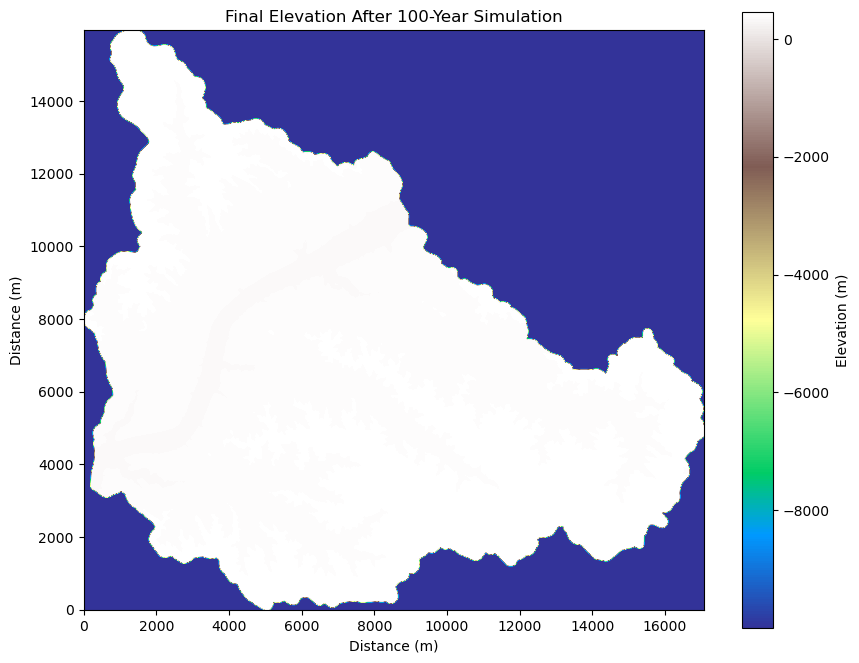

In [14]:
from landlab import RasterModelGrid
from landlab.components import LinearDiffuser, ErosionDeposition, FlowAccumulator
import numpy as np
import matplotlib.pyplot as plt
from rasterio import open as rio_open
from rasterio.transform import from_origin
from rasterio import Affine
# Now that the 3 meter DEM is loaded and the Landlab grid is initialized, we can proceed with the next steps.
# ---------------------------------------------------------------------------
# Step 1: Load the 3-meter DEM and Initialize the Landlab Grid
# ---------------------------------------------------------------------------
dem_path = r"E:\Landlab\3m_clipped_Beamon.tif"

with rio_open(dem_path) as src:
    dem_data = src.read(1)  # Read first band (elevation values)
    nodata_value = src.nodata  # Retrieve NoData value (-9999)
    pixel_size = src.transform[0]  # Pixel size (3 meters)
    transform = src.transform  # Affine transform
    crs = src.crs  # Coordinate reference system (CRS)
    nrows, ncols = dem_data.shape  # DEM dimensions

# Replace nodata values in the DEM
dem_cleaned = np.where(dem_data == nodata_value, -9999, dem_data)

# Initialize the Landlab RasterModelGrid
grid = RasterModelGrid((nrows, ncols), xy_spacing=pixel_size)

# Add the elevation field to the grid
elevation = grid.add_field(
    "topographic__elevation", 
    dem_cleaned.flatten(), 
    at="node"
)

# Set the watershed boundary conditions using node 491 as the outlet
grid.set_watershed_boundary_condition_outlet_id(
    outlet_id=491, 
    node_data=elevation, 
    nodata_value=-9999
)

print("Watershed boundary conditions set successfully!")

# ---------------------------------------------------------------------------
# Step 2: Initialize Landlab Components
# ---------------------------------------------------------------------------
# Flow Accumulator
flow_accumulator = FlowAccumulator(grid, flow_director="D8")

# Linear Diffuser for soil creep
linear_diffuser = LinearDiffuser(grid, linear_diffusivity=0.01)  # m²/yr

# Erosion Deposition for erosion and sediment transport
erosion_deposition = ErosionDeposition(
    grid,
    K=0.00046,  # Erodibility factor (adjustable)
    F_f=0.5,    # Fraction of fine sediment
    v_s=0.001,  # Settling velocity (m/s)
)

# ---------------------------------------------------------------------------
# Step 3: Run the Simulation for 100 Years
# ---------------------------------------------------------------------------
n_years = 100

for t in range(n_years):
    flow_accumulator.run_one_step()       # Update flow fields
    linear_diffuser.run_one_step(1.0)    # Soil creep for 1 year
    erosion_deposition.run_one_step(1.0) # Erosion and deposition for 1 year
    if t % 10 == 0:  # Print progress every 10 years
        print(f"Year {t} completed.")

# ---------------------------------------------------------------------------
# Step 4: Save the Final DEM as a Raster
# ---------------------------------------------------------------------------
# Get the final elevation field
final_elevation = grid.at_node["topographic__elevation"].reshape((nrows, ncols))

# Replace any closed nodes or nodata values with -9999
final_elevation_cleaned = np.where(final_elevation == -9999, nodata_value, final_elevation)

# Save the final DEM to a GeoTIFF
output_path = r"E:\Landlab\3m_clipped_Beamon_FinalDEM_100years.tif"
with rio_open(
    output_path,
    "w",
    driver="GTiff",
    height=nrows,
    width=ncols,
    count=1,
    dtype=final_elevation_cleaned.dtype.name,
    crs=crs,
    transform=transform,
    nodata=nodata_value
) as dst:
    dst.write(final_elevation_cleaned, 1)

print(f"Final DEM saved to {output_path}")

# ---------------------------------------------------------------------------
# Step 5: Visualize the Final Elevation
# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 8))
plt.imshow(final_elevation_cleaned, cmap="terrain", extent=(
    0, ncols * pixel_size,
    0, nrows * pixel_size
))
plt.colorbar(label="Elevation (m)")
plt.title("Final Elevation After 100-Year Simulation")
plt.xlabel("Distance (m)")
plt.ylabel("Distance (m)")
plt.show()


Watershed boundary conditions set successfully!


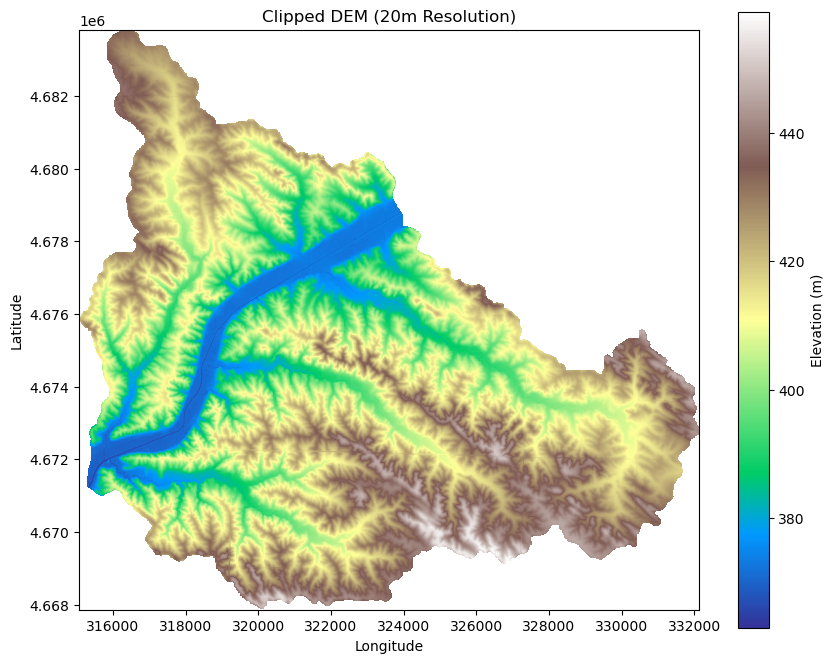

Number of rows (20m): 798
Number of columns (20m): 853
Cell spacing (20m): 20.0
NoData value (20m): -9999.0
Minimum elevation (20m): 362.9200134277344
Maximum elevation (20m): 458.8599853515625


In [18]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.mask import mask
from landlab import RasterModelGrid
import matplotlib.pyplot as plt
# This one is a 20 m DEM not clipped to the watershed shapefile 
# ---------------------------------------------------------------------------
# Step 1: File Paths and Data Import/ Preparing DEM of watershed for modelling
# ---------------------------------------------------------------------------
dem_20m_path = r"E:\Landlab\beamon_20_m.asc"  # 20-meter DEM
watershed_20m_path = r"E:\Projects in Modelling\New Folder\beamon_01_buffered.shp"  # Watershed shapefile

# Load the watershed shapefile using GeoPandas
watershed_20m = gpd.read_file(watershed_20m_path)

# ---------------------------------------------------------------------------
# Step 2: Load DEM and Ensure CRS Consistency
# ---------------------------------------------------------------------------
with rasterio.open(dem_20m_path) as src_20m:
    # Extract DEM data and metadata
    dem_20m_data = src_20m.read(1)
    no_data_val_20m = src_20m.nodata  # Should be -9999.0
    transform_20m = src_20m.transform
    dem_20m_crs = src_20m.crs
    
    # Ensure the watershed CRS matches the DEM
    watershed_20m = watershed_20m.to_crs(dem_20m_crs)
    
    # Clip the DEM to the watershed extent
    out_image_20m, out_transform_20m = mask(src_20m, watershed_20m.geometry, crop=True)
    clipped_dem_20m = out_image_20m[0]  # Extract the clipped DEM array

# ---------------------------------------------------------------------------
# Step 3: Create a Landlab RasterModelGrid
# ---------------------------------------------------------------------------
# Determine rows, columns, and cell spacing
nrows_20m, ncols_20m = clipped_dem_20m.shape
spacing_20m = transform_20m[0]  # Pixel size (20.0)

# Initialize the Landlab grid
grid_20m = RasterModelGrid((nrows_20m, ncols_20m), xy_spacing=spacing_20m)

# Add elevation field (clipped DEM)
elevation_20m = grid_20m.add_field(
    "topographic__elevation", 
    clipped_dem_20m.flatten(), 
    at="node"
)

# Mask out NoData nodes and set as closed nodes
mask = clipped_dem_20m != no_data_val_20m  # True for valid nodes
grid_20m.status_at_node[~mask.flatten()] = grid_20m.BC_NODE_IS_CLOSED
# ---------------------------------------------------------------------------
# Set watershed boundary conditions
grid_20m.set_watershed_boundary_condition(
    elevation_20m, nodata_value=no_data_val_20m
)

print("Watershed boundary conditions set successfully!")
# ---------------------------------------------------------------------------
# Step 5: Plot the Clipped DEM
# ---------------------------------------------------------------------------
valid_dem_20m = np.where(clipped_dem_20m == no_data_val_20m, np.nan, clipped_dem_20m)

plt.figure(figsize=(10, 8))
plt.imshow(valid_dem_20m, cmap='terrain', extent=(
    out_transform_20m[2], 
    out_transform_20m[2] + out_transform_20m[0] * ncols_20m,
    out_transform_20m[5] + out_transform_20m[4] * nrows_20m, 
    out_transform_20m[5]
))
plt.colorbar(label='Elevation (m)')
plt.title('Clipped DEM (20m Resolution)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# ---------------------------------------------------------------------------
# Step 6: Print Relevant Information
# ---------------------------------------------------------------------------
print(f"Number of rows (20m): {nrows_20m}")
print(f"Number of columns (20m): {ncols_20m}")
print(f"Cell spacing (20m): {spacing_20m}")
print(f"NoData value (20m): {no_data_val_20m}")
print(f"Minimum elevation (20m): {np.min(valid_dem_20m[~np.isnan(valid_dem_20m)])}")
print(f"Maximum elevation (20m): {np.max(valid_dem_20m[~np.isnan(valid_dem_20m)])}")

Year 0 completed.
Year 10 completed.
Year 20 completed.
Year 30 completed.
Year 40 completed.
Year 50 completed.
Year 60 completed.
Year 70 completed.
Year 80 completed.
Year 90 completed.


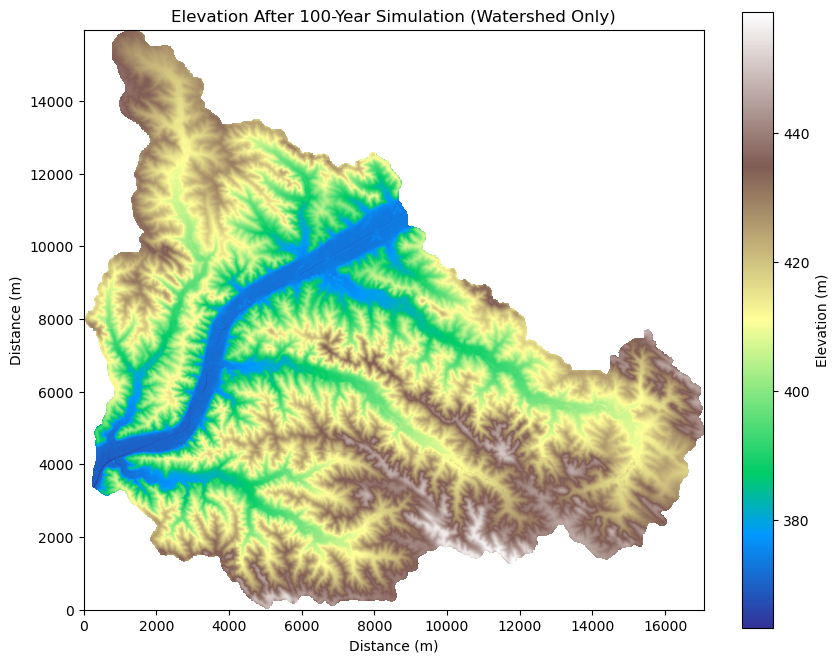

In [20]:
from landlab.components import LinearDiffuser, ErosionDeposition, FlowAccumulator
import numpy as np
import matplotlib.pyplot as plt
from landlab import RasterModelGrid
from rasterio import open as rio_open

# ---------------------------------------------------------------------------
# Step 1: Initialize Landlab Grid/ combining LinearDiffuser and ErosionDeposition
# for a 50-year simulation on your low-relief hillslope grid.
# ---------------------------------------------------------------------------
# Assuming 'grid_20m' is already defined with your clipped DEM
# If not, reload it as follows:
dem_20m_path = r"E:\Landlab\beamon_20_m.asc"

with rio_open(dem_20m_path) as src_20m:
    clipped_dem_20m = src_20m.read(1)
    no_data_val_20m = src_20m.nodata
    clipped_dem_20m_cleaned = np.where(clipped_dem_20m == no_data_val_20m, -9999, clipped_dem_20m)
    clipped_dem_20m_cleaned = clipped_dem_20m_cleaned.astype(np.float64)
    spacing_20m = src_20m.transform[0]

nrows_20m, ncols_20m = clipped_dem_20m_cleaned.shape
grid_20m = RasterModelGrid((nrows_20m, ncols_20m), xy_spacing=spacing_20m)
elevation_20m = grid_20m.add_field("topographic__elevation", clipped_dem_20m_cleaned.flatten(), at="node")
grid_20m.set_watershed_boundary_condition(elevation_20m, nodata_value=-9999)

# ---------------------------------------------------------------------------
# Step 2: Initialize Components
# ---------------------------------------------------------------------------
flow_accumulator = FlowAccumulator(grid_20m, flow_director="D8")
flow_accumulator.run_one_step()  # Generate flow fields
# Linear Diffuser: Models diffusion-like soil creep
linear_diffuser = LinearDiffuser(grid_20m, linear_diffusivity=0.01)  # m²/yr

# ErosionDeposition: Models erosion, transport, and deposition
linear_diffuser = LinearDiffuser(grid_20m, linear_diffusivity=0.01)  # Soil creep
erosion_deposition = ErosionDeposition(
    grid_20m,
    K=0.00046,  # Erodibility factor (converted K value)
    F_f=0.5,    # Fraction of fine sediment
    v_s=0.001,  # Settling velocity (m/s)
)

# ---------------------------------------------------------------------------
# Step 3: Run Simulation for 100 Years
# ---------------------------------------------------------------------------
n_years = 100
for t in range(n_years):
    flow_accumulator.run_one_step()  # Update flow fields
    linear_diffuser.run_one_step(1.0)  # Run LinearDiffuser for 1 year
    erosion_deposition.run_one_step(1.0)  # Run ErosionDeposition for 1 year
    if t % 10 == 0:  # Print progress every 10 years
        print(f"Year {t} completed.")
# ---------------------------------------------------------------------------
# Step 4: Plot Final Results
# ---------------------------------------------------------------------------
# Plot only the watershed results
# Reshape topographic__elevation to match the grid shape
elevation_reshaped = grid_20m.at_node["topographic__elevation"].reshape((nrows_20m, ncols_20m))

# Apply the mask to filter only valid watershed values
final_elevation = np.where(mask, elevation_reshaped, np.nan)

# Plot the results
plt.figure(figsize=(10, 8))
plt.imshow(final_elevation, cmap="terrain", extent=(
    0, ncols_20m * spacing_20m,
    0, nrows_20m * spacing_20m
))
plt.colorbar(label="Elevation (m)")
plt.title("Elevation After 100-Year Simulation (Watershed Only)")
plt.xlabel("Distance (m)")
plt.ylabel("Distance (m)")
plt.show()


Compatible raster saved successfully to: E:\Landlab\final_elevation_100yr.tif


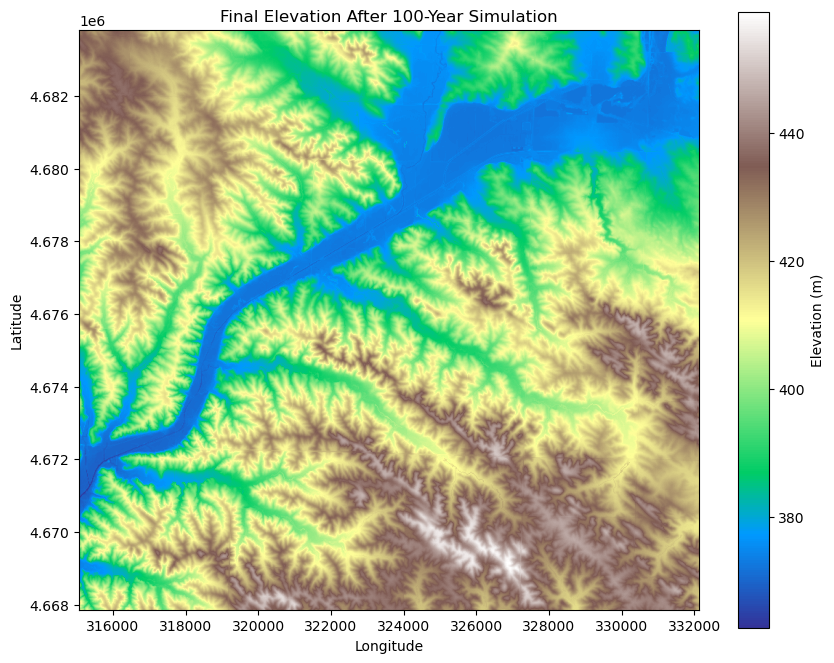

Compatible raster saved successfully to: E:\Landlab\final_elevation_100yr.tif


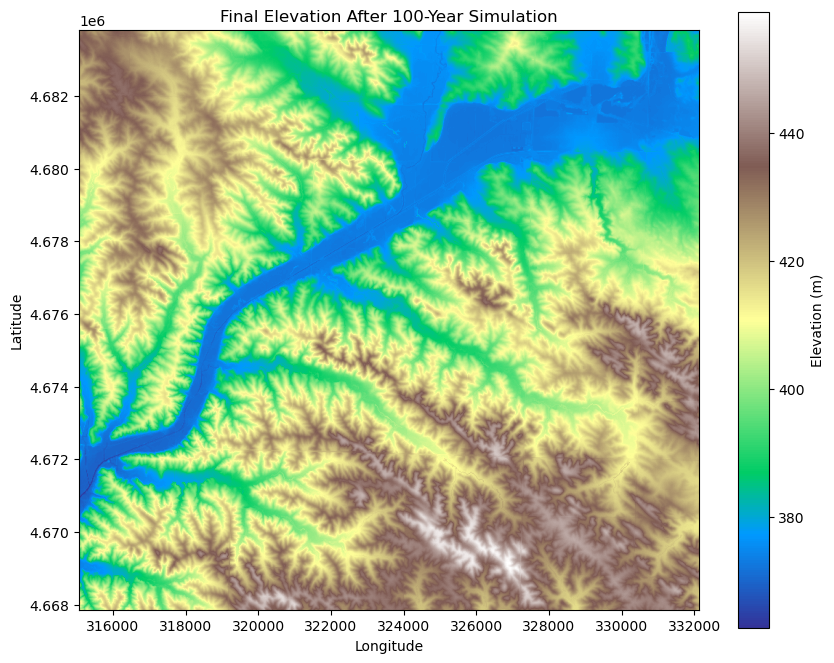

In [ ]:
import rasterio
from rasterio.transform import from_origin

# ---------------------------------------------------------------------------
# Step 1: Open the Original Raster (Dtm_final.rst) for Metadata saving the
# final elevation data to a new raster file that matches the original metadata.
# from the orighinal raster to the 100 year simulation raster.
# ---------------------------------------------------------------------------
original_raster_path = r"C:\watem-sedem-5.0.2\watem_sedem\Beamon_Creek\Input\Dtm_final.rst"
output_raster_path = r"E:\Landlab\final_elevation_100yr.tif"  # Output file path

with rasterio.open(original_raster_path) as src_orig:
    original_transform = src_orig.transform
    original_crs = src_orig.crs
    original_resolution = (src_orig.res[0], src_orig.res[1])  # (x, y) resolution
    original_bounds = src_orig.bounds
    original_width = src_orig.width
    original_height = src_orig.height

# ---------------------------------------------------------------------------
# Step 2: Prepare Final Elevation Data (Landlab Output)
# ---------------------------------------------------------------------------
final_elevation = grid_20m.at_node["topographic__elevation"].reshape((nrows_20m, ncols_20m))

# Ensure the final raster matches the dimensions of the original
if (final_elevation.shape != (original_height, original_width)):
    raise ValueError("Final elevation raster dimensions do not match the original raster.")

# ---------------------------------------------------------------------------
# Step 3: Write the Final Raster to Match Original Metadata
# ---------------------------------------------------------------------------
with rasterio.open(
    output_raster_path,
    "w",
    driver="GTiff",
    height=original_height,
    width=original_width,
    count=1,  # Single band
    dtype="float32",
    crs=original_crs,  # Use CRS from the original raster
    transform=original_transform,  # Use transform from the original raster
    nodata=-9999
) as dst:
    dst.write(final_elevation.astype("float32"), 1)

print(f"Compatible raster saved successfully to: {output_raster_path}")

# Plot the final elevation
plt.figure(figsize=(10, 8))
plt.imshow(final_elevation, cmap='terrain', extent=(
    original_bounds.left, 
    original_bounds.right, 
    original_bounds.bottom, 
    original_bounds.top
))
plt.colorbar(label='Elevation (m)')
plt.title('Final Elevation After 100-Year Simulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
from rasterio.transform import from_origin

# ---------------------------------------------------------------------------
# Step 1: Open the Original Raster (Dtm_final.rst) for Metadata
# ---------------------------------------------------------------------------
original_raster_path = r"C:\watem-sedem-5.0.2\watem_sedem\Beamon_Creek\Input\Dtm_final.rst"
output_raster_path = r"E:\Landlab\final_elevation_100yr.tif"  # Output file path

with rasterio.open(original_raster_path) as src_orig:
    original_transform = src_orig.transform
    original_crs = src_orig.crs
    original_resolution = (src_orig.res[0], src_orig.res[1])  # (x, y) resolution
    original_bounds = src_orig.bounds
    original_width = src_orig.width
    original_height = src_orig.height

# ---------------------------------------------------------------------------
# Step 2: Prepare Final Elevation Data (Landlab Output)
# ---------------------------------------------------------------------------
final_elevation = grid_20m.at_node["topographic__elevation"].reshape((nrows_20m, ncols_20m))

# Ensure the final raster matches the dimensions of the original
if (final_elevation.shape != (original_height, original_width)):
    raise ValueError("Final elevation raster dimensions do not match the original raster.")

# ---------------------------------------------------------------------------
# Step 3: Write the Final Raster to Match Original Metadata
# ---------------------------------------------------------------------------
with rasterio.open(
    output_raster_path,
    "w",
    driver="GTiff",
    height=original_height,
    width=original_width,
    count=1,  # Single band
    dtype="float32",
    crs=original_crs,  # Use CRS from the original raster
    transform=original_transform,  # Use transform from the original raster
    nodata=-9999
) as dst:
    dst.write(final_elevation.astype("float32"), 1)

print(f"Compatible raster saved successfully to: {output_raster_path}")

# Plot the final elevation
plt.figure(figsize=(10, 8))
plt.imshow(final_elevation, cmap='terrain', extent=(
    original_bounds.left, 
    original_bounds.right, 
    original_bounds.bottom, 
    original_bounds.top
))
plt.colorbar(label='Elevation (m)')
plt.title('Final Elevation After 100-Year Simulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()